# #############################


In [2]:
! ls

sample_data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# RUN 2 - SHARPER FOCUS ON FEATURE SELECTION AND ENGINEERING

# Model Results Analysis So Far (See Notebook file: 207_FP_LFTV_Run_2_VSAPR5.ipynb)

    The heartbeat of a Customer Lifetime Value (CLV) are average purchase value, purchase frequency, total sales, customer lifespan. However, we had to calculate a ground truth for our data set —- calculate the CLV label for our examples because this label was missing —- and in calculation of this label we use these three variables and added some gaussian noise to calculate the label CLV.

    To prevent data leakage, we excluded average purchase value, purchase frequency, total sales, customer lifespan from our model runs. Both Linear Regression and FFNN Regression that we just ran did not use these features. This led to Validation RMSEs of 178.29% and 178% respectively from the two models. Such high validation RMSEs compare with similar experimental runs we did earlier that included a slightly different set of features but also did not include average purchase value, purchase frequency, total sales, customer lifespan as features (one such similar run earlier produced a validation RMSE of 92089.17, also very high).

    In real world, a business may choose to be OK with such large RMSEs. Why? Because CLV values are DIRECTIONAL indicators, and decisions are not made on the absolute value of a CLV for a customer. CLVs are used for comparisons, and thus a higher RMSE may indeed be acceptable. In addition, a marketing team may also exercise experience to produce CLV labels.

    But to complete our story, we will launch another run of CLV modeling. Now, we will use average purchase value, purchase frequency, total sales, membership years (a better (less direct) proxy for customer lifespan) as features in the model, but adjust each of them to include some noise. Our model will include noise-adjusted versions of each of these features.


# MODEL RUN PHASE 2
    Include noise-adjusted versions of ‘adjusted_avg_purch_val’, 'adjusted_purchase_frequency', 'adjusted_membership_years’, 'adjusted_total_sales' in the model.

    We will also consider addition of some new, and dropping of existing features.

    We will run Model Phase 2 in this notebook.

# SECTION: Library Installations and GPU checks

In [4]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU (Metal) is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 1


In [5]:
import tensorflow as tf
import time

# Create a large random tensor
tensor_a = tf.random.normal([1000, 1000])
tensor_b = tf.random.normal([1000, 1000])

# Perform matrix multiplication on GPU
start_time = time.time()
result = tf.matmul(tensor_a, tensor_b)
end_time = time.time()

print("Time taken for matrix multiplication:", end_time - start_time, "seconds")

Time taken for matrix multiplication: 0.17737865447998047 seconds


# SECTION: Imports and more Libary Installs

In [ ]:
#! brew install cmake

In [ ]:
#! pip install tensorflow-datasets

In [ ]:
# ! pip install scikit-learn

In [ ]:
# ! pip install shap


In [7]:
! pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 12.6 MB/s eta 0:00:00


In [72]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow_datasets as tfds
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model


from scipy import stats
from scipy.stats import boxcox

import keras
import keras_tuner as kt

from keras import layers, models
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# shap
#import shap

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA
#from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


random.seed(42)
%matplotlib inline

# FILL IN CODE HERE #
RANDOM_SAMPLES_VAL = 500000 #To make computing on local machine, colab palatable, we will use a random sample for the exercise
RANDOM_STATE = 42

# Feature Engineering Phase 2, domain understanding, and impact of feature on Y as from correlation matrix:

    We will drop demographic features: age, number_of_children, education_level, occupation, marital_status, total_items_purchased

    We will retain customer_support_calls, income_bracket, loyalty_program’ (since we are using adjusted_membership_years)


    Our new selected set of features:
    ‘adjusted_avg_purch_val’, 'adjusted_purchase_frequency', 'adjusted_membership_years’, 'adjusted_total_sales’,
    ‘customer_support_calls’,’income_bracket’, 'avg_transaction_value’, 'total_returned_value’,
    'app_usage','website_visits','social_media_engagement', 'days_since_last_purchase’,
    'total_discounts_received’, 'total_transactions’

    Note that features marked as adjusted would noisy counterparts to their unadulterated forms.

    These features cover a good mix of transactions, purchase, channel interaction, promotion sensitivity, demographics, and dissatisfaction (e.g. returns).

    Our pre-adjusted set of features:
        'avg_purchase_value','purchase_frequency','membership_years’,’total_sales’,
        ‘customer_support_calls’,’income_bracket’, 'avg_transaction_value’, 'total_returned_value’,
        'app_usage','website_visits','social_media_engagement', 'days_since_last_purchase’,
        'total_discounts_received’, 'total_transactions’

    desired_columns = ['avg_purchase_value','purchase_frequency','membership_years','total_sales',
        'customer_support_calls','income_bracket', 'avg_transaction_value', 'total_returned_value',
        'app_usage','website_visits','social_media_engagement', 'days_since_last_purchase',
        'total_discounts_received', 'total_transactions']

# SECTION: Our helper and utility functions

In [9]:
#VS - II helpful functions

# summarizes a data frame in a printer friendly way
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes.values,
        'Null Count': df.isnull().sum().values,
        'Non-Null Count': df.notnull().sum().values,
        'Unique Count': df.nunique().values
    })
    return summary

# SECTION: Data Load

In [10]:
#Retail Data.csv is our master data file from Kaggle
file_path = '/content/drive/MyDrive/ColabNotebooks/retail_data.csv'
retail_df = pd.read_csv(file_path)

In [11]:
retail_df.head()

,customer_id,age,gender,income_bracket,loyalty_program,membership_years,churned,marital_status,number_of_children,education_level,...,distance_to_store,holiday_season,season,weekend,customer_support_calls,email_subscriptions,app_usage,website_visits,social_media_engagement,days_since_last_purchase
0,1,56,Other,High,No,0,No,Divorced,3,Bachelor's,...,33.21,No,Spring,Yes,5,No,High,30,High,40
1,2,69,Female,Medium,No,2,No,Married,2,PhD,...,62.56,No,Summer,Yes,6,No,High,40,Medium,338
2,3,46,Female,Low,No,5,No,Married,3,Bachelor's,...,83.04,Yes,Winter,Yes,2,Yes,Low,89,Medium,61
3,4,32,Female,Low,No,0,No,Divorced,2,Master's,...,50.43,Yes,Winter,No,12,No,Low,12,Low,42
4,5,60,Female,Low,Yes,7,Yes,Divorced,2,Bachelor's,...,36.55,Yes,Summer,Yes,3,No,Medium,31,Low,242


In [12]:
retail_df.shape

(1000000, 78)

In [13]:
summarize_dataframe(retail_df)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,customer_id,int64,0,1000000,1000000
1,age,int64,0,1000000,62
2,gender,object,0,1000000,3
3,income_bracket,object,0,1000000,3
4,loyalty_program,object,0,1000000,2
...,...,...,...,...,...
73,email_subscriptions,object,0,1000000,2
74,app_usage,object,0,1000000,3
75,website_visits,int64,0,1000000,100
76,social_media_engagement,object,0,1000000,3


In [14]:
retail_df.iloc[:5]

,customer_id,age,gender,income_bracket,loyalty_program,membership_years,churned,marital_status,number_of_children,education_level,...,distance_to_store,holiday_season,season,weekend,customer_support_calls,email_subscriptions,app_usage,website_visits,social_media_engagement,days_since_last_purchase
0,1,56,Other,High,No,0,No,Divorced,3,Bachelor's,...,33.21,No,Spring,Yes,5,No,High,30,High,40
1,2,69,Female,Medium,No,2,No,Married,2,PhD,...,62.56,No,Summer,Yes,6,No,High,40,Medium,338
2,3,46,Female,Low,No,5,No,Married,3,Bachelor's,...,83.04,Yes,Winter,Yes,2,Yes,Low,89,Medium,61
3,4,32,Female,Low,No,0,No,Divorced,2,Master's,...,50.43,Yes,Winter,No,12,No,Low,12,Low,42
4,5,60,Female,Low,Yes,7,Yes,Divorced,2,Bachelor's,...,36.55,Yes,Summer,Yes,3,No,Medium,31,Low,242


In [15]:
retail_df.columns

Index(['customer_id', 'age', 'gender', 'income_bracket', 'loyalty_program',
       'membership_years', 'churned', 'marital_status', 'number_of_children',
       'education_level', 'occupation', 'transaction_id', 'transaction_date',
       'product_id', 'product_category', 'quantity', 'unit_price',
       'discount_applied', 'payment_method', 'store_location',
       'transaction_hour', 'day_of_week', 'week_of_year', 'month_of_year',
       'avg_purchase_value', 'purchase_frequency', 'last_purchase_date',
       'avg_discount_used', 'preferred_store', 'online_purchases',
       'in_store_purchases', 'avg_items_per_transaction',
       'avg_transaction_value', 'total_returned_items', 'total_returned_value',
       'total_sales', 'total_transactions', 'total_items_purchased',
       'total_discounts_received', 'avg_spent_per_category',
       'max_single_purchase_value', 'min_single_purchase_value',
       'product_name', 'product_brand', 'product_rating',
       'product_review_count', '

# Initial EDA Comments: Initial Observations of our data set

    - Shape: 1000000 x 78. 1 M rows, 78 columns
    - No columns have nulls / missing values.
    - Names of all columns are lower case, with no spaces, and use underscore. Names of all columns seem nicely formatted.

# Business Logic and Data Issue Mitigation
    Data does not have ground truth for Customer Lifetime Value (CLV) which is typically a formulaic calculation based on
    Average Purchase Value x Purchase Frtequency x Customer Lifespan (CL)

    CL does not exist in data, so we derive it from loyalty membership years using a conditional logic.
    
    Final CLV = mean of calucations from APV x PF x CL, and Total sales x CL. We also add some random noise to the calculated CLV to estimate final CLV for a sample.

In [16]:
##Business logic calucation functions

def calculate_CL(membership_years):
    ## Caculates Customer lifespan in years
    # from (loyalty) membership years.

    #cl = customer lifespan in years (can be fraction)
    cl = 0.0
    #1 calcuate CLV1 from membership years
    if (membership_years >= 7.0 ):
        cl  = 0.6 * membership_years
    elif (membership_years >= 4) & (membership_years < 7.0):
        cl = 0.8 * membership_years
    elif (membership_years > 0) & (membership_years < 4.0):
        cl = 1 * membership_years
    else:
        cl = 0.5 # for loyalty membership =0 years
    return cl

def map_purchase_freq_to_nums(purchase_frequency):
    ##takes in daily, weekly, yearly labels for purchase frequency
    # and converts it to a number using a rules formula
    frequency_map = {
        'Daily': 365,
        'Weekly': 52,
        'Monthly': 12,
        'Yearly': 1
    }
    return frequency_map.get(purchase_frequency)


def calculate_CLV(average_purchase_value, purchase_frequency,customer_lifespan,total_sales, add_noise_std_dev=0.1):
    ## calculates the (ground truth) customer lifetime value from
    #average pruchase value, purchase frequency, and total sales

    clv1 = float(average_purchase_value) * float(purchase_frequency) * float(customer_lifespan)
    clv2 = total_sales * customer_lifespan
    clv = (clv1 + clv2) / 2.0

    #Now we will add some noise to the growth truth clv calculation
    # Add Gaussian noise (normal distribution centered at 0, with standard deviation add_noise_std_dev * base calcuated clv)
    noise = np.random.normal(0, add_noise_std_dev * clv)
    clv = clv + noise

    return clv

In [17]:
#extract customer lifespan
retail_df['customer_lifespan'] = retail_df['membership_years'].apply(calculate_CL)
#convert purchase frequency to integer values
retail_df['purchase_frequency'] = retail_df['purchase_frequency'].apply(map_purchase_freq_to_nums)

In [18]:
#Cacluate customer_lifetime_value
retail_df['customer_lifetime_value'] = retail_df.apply(lambda row: calculate_CLV(row['avg_purchase_value'],
                                                                                 row['purchase_frequency'],
                                                                                 row['customer_lifespan'],
                                                                                 row['total_sales']), axis=1)
mean_clv = retail_df['customer_lifetime_value'].mean()



In [19]:
retail_df.shape

(1000000, 80)

In [20]:
retail_df.columns

Index(['customer_id', 'age', 'gender', 'income_bracket', 'loyalty_program',
       'membership_years', 'churned', 'marital_status', 'number_of_children',
       'education_level', 'occupation', 'transaction_id', 'transaction_date',
       'product_id', 'product_category', 'quantity', 'unit_price',
       'discount_applied', 'payment_method', 'store_location',
       'transaction_hour', 'day_of_week', 'week_of_year', 'month_of_year',
       'avg_purchase_value', 'purchase_frequency', 'last_purchase_date',
       'avg_discount_used', 'preferred_store', 'online_purchases',
       'in_store_purchases', 'avg_items_per_transaction',
       'avg_transaction_value', 'total_returned_items', 'total_returned_value',
       'total_sales', 'total_transactions', 'total_items_purchased',
       'total_discounts_received', 'avg_spent_per_category',
       'max_single_purchase_value', 'min_single_purchase_value',
       'product_name', 'product_brand', 'product_rating',
       'product_review_count', '

# MILESTONE: we have our ground truth Y label (customer lifetime value)
    1. Note: This ground truth Y label for customer lifetime value has some noise built into it.

# Extract features for Lifetime value modeling

In [21]:
## Select a random sample of RANDOM_SAMPLES_VAL (e.g. 100K) rows to make the ML model run on limited compute resources
retail_df = retail_df.sample(n=RANDOM_SAMPLES_VAL, random_state=RANDOM_STATE)

In [22]:
retail_df.shape

(500000, 80)

In [23]:
retail_df['customer_id'].nunique()

500000

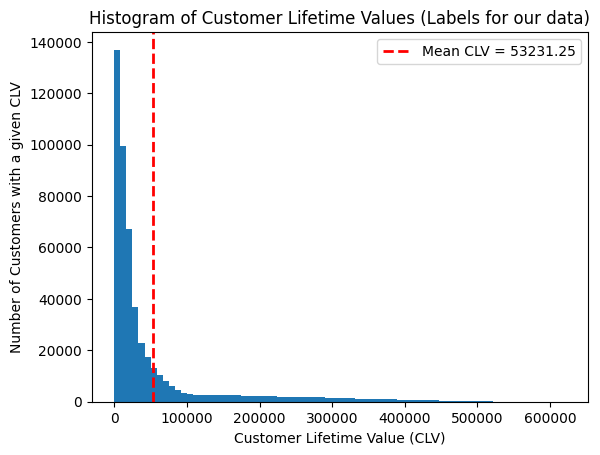

retail_df.shape =(500000, 80)


In [24]:
# Visualize Y distribution
#Visualize
plt.clf()
plt.hist(retail_df['customer_lifetime_value'], bins=75)
plt.axvline(mean_clv, color='red', linestyle='dashed', linewidth=2, label=f'Mean CLV = {mean_clv:.2f}')
plt.xlabel('Customer Lifetime Value (CLV)')
plt.ylabel('Number of Customers with a given CLV')
plt.title('Histogram of Customer Lifetime Values (Labels for our data)')
plt.legend()
plt.show()
print(f"{retail_df.shape =}")

#
    Our Y is skewed, and has outliers. We will address this more detail a little later.

# FEATURE SELECTION based on domain knowledge

    As mentioned above, our seelected features are:

    desired_columns = ['avg_purchase_value','purchase_frequency','membership_years','total_sales',
        'customer_support_calls','income_bracket', 'avg_transaction_value', 'total_returned_value',
        'app_usage','website_visits','social_media_engagement', 'days_since_last_purchase',
        'total_discounts_received', 'total_transactions']

In [25]:
desired_columns = ['avg_purchase_value','purchase_frequency','membership_years','total_sales',
        'customer_support_calls','income_bracket', 'avg_transaction_value', 'total_returned_value',
        'app_usage','website_visits','social_media_engagement', 'days_since_last_purchase',
        'total_discounts_received', 'total_transactions', 'customer_lifetime_value' ]
lftv_data = retail_df[desired_columns]
lftv_data.shape

(500000, 15)

In [26]:
summarize_dataframe(lftv_data)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,avg_purchase_value,float64,0,500000,48999
1,purchase_frequency,int64,0,500000,4
2,membership_years,int64,0,500000,10
3,total_sales,float64,0,500000,392605
4,customer_support_calls,int64,0,500000,20
5,income_bracket,object,0,500000,3
6,avg_transaction_value,float64,0,500000,48998
7,total_returned_value,float64,0,500000,99371
8,app_usage,object,0,500000,3
9,website_visits,int64,0,500000,100


# Feature Engineering Workflow

    1) Add noise-adjusted columns. Drop their 'pure' counterparts
    2) Encode categorical features
    3) Address skewness, outliers in Y through transformation.
    4) Standard scale numeric features.

In [27]:
#add noise to 'avg_purchase_value', 'purchase_frequency', 'membership_years', 'total_sales'
add_noise_std_dev = 0.05
lftv_data['adjusted_avg_purch_val'] = \
        lftv_data['avg_purchase_value'].apply(lambda x: x + np.random.normal(0, add_noise_std_dev * x))
lftv_data['adjusted_purchase_frequency'] = \
        lftv_data['purchase_frequency'].apply(lambda x: x + np.random.normal(0, add_noise_std_dev * x))
lftv_data['adjusted_membership_years'] = \
        lftv_data['membership_years'].apply(lambda x: x + np.random.normal(0, add_noise_std_dev * x))
lftv_data['adjusted_total_sales'] = \
        lftv_data['total_sales'].apply(lambda x: x + np.random.normal(0, add_noise_std_dev * x))

In [28]:
columns_to_drop = ['avg_purchase_value', 'purchase_frequency', 'membership_years', 'total_sales']
lftv_data = lftv_data.drop(columns=columns_to_drop)

In [29]:
lftv_data.head()

,customer_support_calls,income_bracket,avg_transaction_value,total_returned_value,app_usage,website_visits,social_media_engagement,days_since_last_purchase,total_discounts_received,total_transactions,customer_lifetime_value,adjusted_avg_purch_val,adjusted_purchase_frequency,adjusted_membership_years,adjusted_total_sales
987231,1,Medium,374.84,170.41,Low,75,High,329,263.01,9,65185.342948,436.070823,52.445359,7.734687,4641.927557
79954,3,Low,127.35,970.63,Medium,77,High,145,104.15,40,4924.237356,479.342255,11.067716,0.966936,3120.011481
567130,14,Medium,190.46,219.24,Medium,52,Low,95,428.12,60,3786.364241,181.676714,53.626157,0.000000,6777.507688
500891,7,High,304.81,723.65,Low,21,Low,124,245.91,11,44788.675155,398.342473,51.541545,3.205386,10012.068758
55399,17,Medium,136.49,32.39,Low,69,Low,240,464.84,17,99992.802636,187.818157,390.082109,2.721934,5421.427767


In [30]:
summarize_dataframe(lftv_data)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,customer_support_calls,int64,0,500000,20
1,income_bracket,object,0,500000,3
2,avg_transaction_value,float64,0,500000,48998
3,total_returned_value,float64,0,500000,99371
4,app_usage,object,0,500000,3
5,website_visits,int64,0,500000,100
6,social_media_engagement,object,0,500000,3
7,days_since_last_purchase,int64,0,500000,365
8,total_discounts_received,float64,0,500000,99326
9,total_transactions,int64,0,500000,99


In [31]:
lftv_data.shape

(500000, 15)

In [32]:
numerical_features = [
    'customer_support_calls', 'avg_transaction_value', 'total_returned_value', 'website_visits', 'days_since_last_purchase',
    'total_discounts_received', 'total_transactions', 'customer_lifetime_value', 'adjusted_avg_purch_val',
    'adjusted_purchase_frequency', 'adjusted_membership_years', 'adjusted_total_sales'
    ]
categorical_features = ['income_bracket', 'app_usage', 'social_media_engagement']


#
    Now encode categorical features

In [33]:
def encode_my_categorical_feature(df, feature_name, mapping=None, nominal=False, drop_first=True):
    """
    Encodes a single categorical feature in the DataFrame. If the cat feature is ordinal a dictionary map
    is expected ('mapping'); if the cat feature is nominal, one hot encoding is used
    from sk learn and the encoded features with English names are added back to the
    orginal data frame. Modified data frame if returned.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        feature_name (str): The column to encode.
        mapping (dict, optional): For ordinal encoding. Required if nominal=False.
        nominal (bool): If True, use OneHotEncoder from sklearn. If False, use mapping.
        drop_first (bool): Whether to drop the first dummy column (for OneHotEncoder).

    Returns:
        pd.DataFrame: The modified DataFrame with encoded feature.
    """
    if nominal:
        encoder = OneHotEncoder(drop='first' if drop_first else None, sparse_output=False)
        encoded = encoder.fit_transform(df[[feature_name]])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([feature_name]), index=df.index)
        df = df.drop(columns=[feature_name])
        df = pd.concat([df, encoded_df], axis=1)
    else:
        if mapping is None:
            raise ValueError("Missing mapping dictionary for ordinal encoding.")
        df[feature_name] = df[feature_name].map(mapping)

    return df


In [34]:
for i in range(len(categorical_features)):
    print(f"{categorical_features[i]}: {np.unique(lftv_data[categorical_features[i]])}")

income_bracket: ['High' 'Low' 'Medium']
app_usage: ['High' 'Low' 'Medium']
social_media_engagement: ['High' 'Low' 'Medium']


#
    Ordinal features have meaningful order. Nominal don't
    Ordinal: income_bracket, app_usage, social_media_engagement
    Nominal: None.

In [35]:
map2 = { 'High': 3, 'Medium': 2, 'Low': 1 }

In [36]:
lftv_data = encode_my_categorical_feature(lftv_data, 'income_bracket', mapping=map2, nominal=False, drop_first=True)

In [37]:
lftv_data = encode_my_categorical_feature(lftv_data, 'app_usage', mapping=map2, nominal=False, drop_first=True)

In [38]:
lftv_data = encode_my_categorical_feature(lftv_data, 'social_media_engagement', mapping=map2, nominal=False, drop_first=True)

In [39]:
summarize_dataframe(lftv_data)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,customer_support_calls,int64,0,500000,20
1,income_bracket,int64,0,500000,3
2,avg_transaction_value,float64,0,500000,48998
3,total_returned_value,float64,0,500000,99371
4,app_usage,int64,0,500000,3
5,website_visits,int64,0,500000,100
6,social_media_engagement,int64,0,500000,3
7,days_since_last_purchase,int64,0,500000,365
8,total_discounts_received,float64,0,500000,99326
9,total_transactions,int64,0,500000,99


In [40]:
lftv_data.head()

,customer_support_calls,income_bracket,avg_transaction_value,total_returned_value,app_usage,website_visits,social_media_engagement,days_since_last_purchase,total_discounts_received,total_transactions,customer_lifetime_value,adjusted_avg_purch_val,adjusted_purchase_frequency,adjusted_membership_years,adjusted_total_sales
987231,1,2,374.84,170.41,1,75,3,329,263.01,9,65185.342948,436.070823,52.445359,7.734687,4641.927557
79954,3,1,127.35,970.63,2,77,3,145,104.15,40,4924.237356,479.342255,11.067716,0.966936,3120.011481
567130,14,2,190.46,219.24,2,52,1,95,428.12,60,3786.364241,181.676714,53.626157,0.000000,6777.507688
500891,7,3,304.81,723.65,1,21,1,124,245.91,11,44788.675155,398.342473,51.541545,3.205386,10012.068758
55399,17,2,136.49,32.39,1,69,1,240,464.84,17,99992.802636,187.818157,390.082109,2.721934,5421.427767


In [41]:
lftv_data.shape

(500000, 15)

# EDA Visualization

<Figure size 640x480 with 0 Axes>

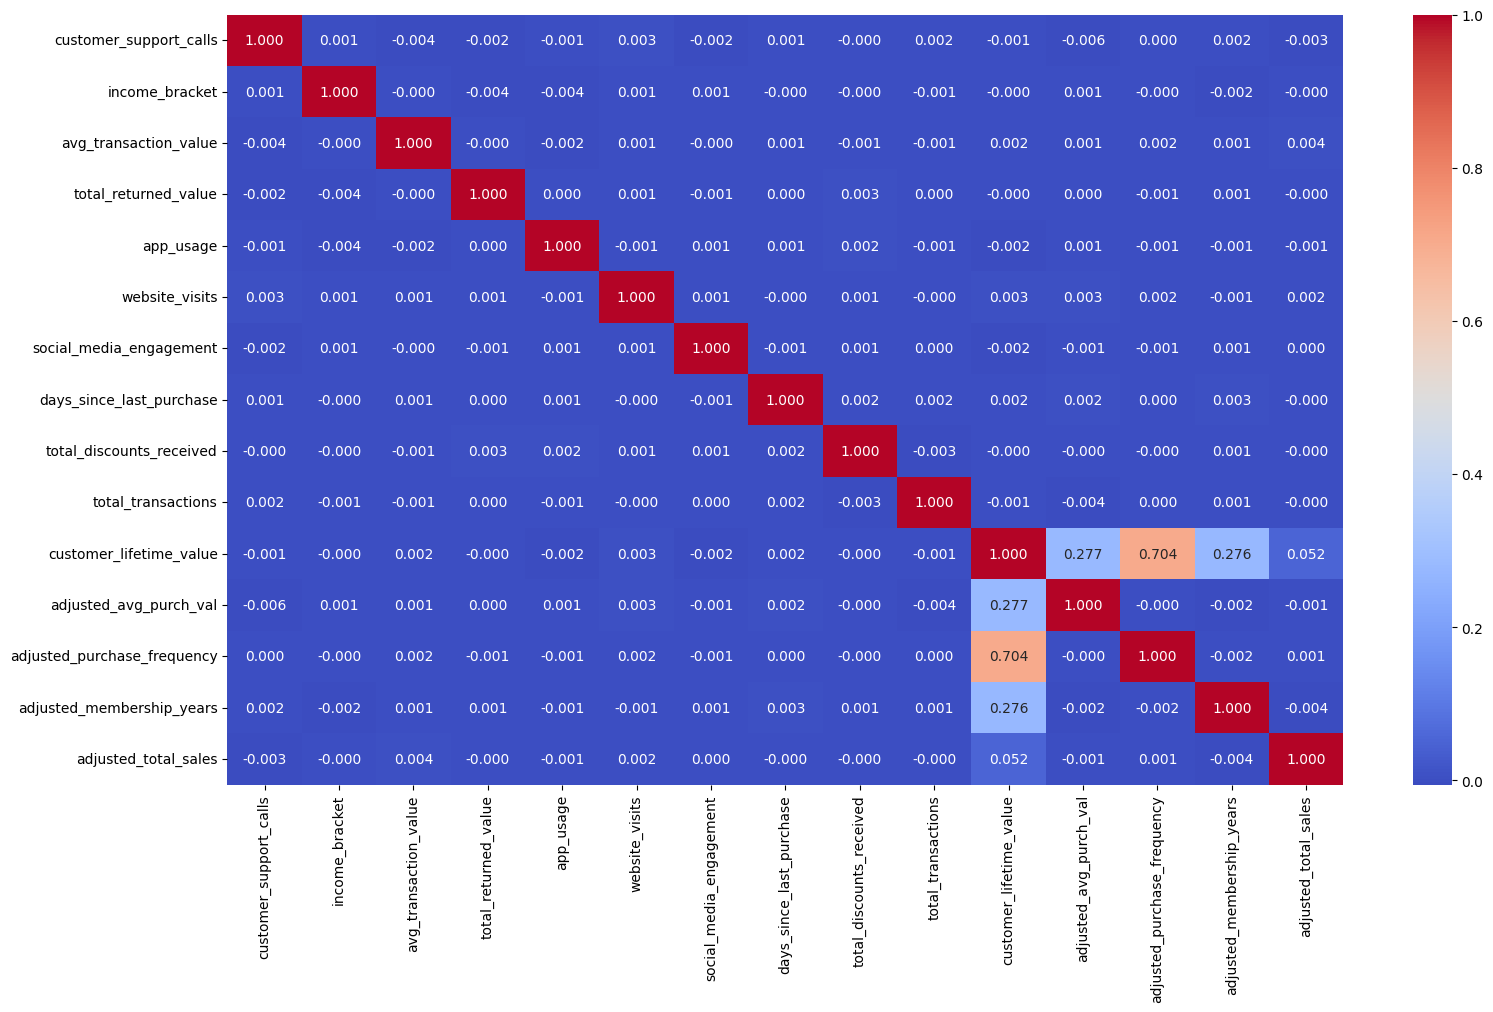

In [42]:
# correlation matrix to visualize relationships
plt.clf()
corr_matrix = lftv_data.corr()
plt.figure(figsize=(18,10))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm')
plt.show()

#
    Based on this correlation matrix, none of the features are strongly correlated, so no candidates for dropping based on this criterion.

    However when we look at correlations of our Y (customer lifetime value), we notice, that Y has zero correlation with customer_support_calls,
    income_bracket, total_returned_value, total_discounts_received. So we will drop these columns.


In [43]:
lftv_data = lftv_data.drop(columns=['customer_support_calls','income_bracket', 'total_returned_value', 'total_discounts_received'])

In [44]:
lftv_data.shape

(500000, 11)

<Figure size 640x480 with 0 Axes>

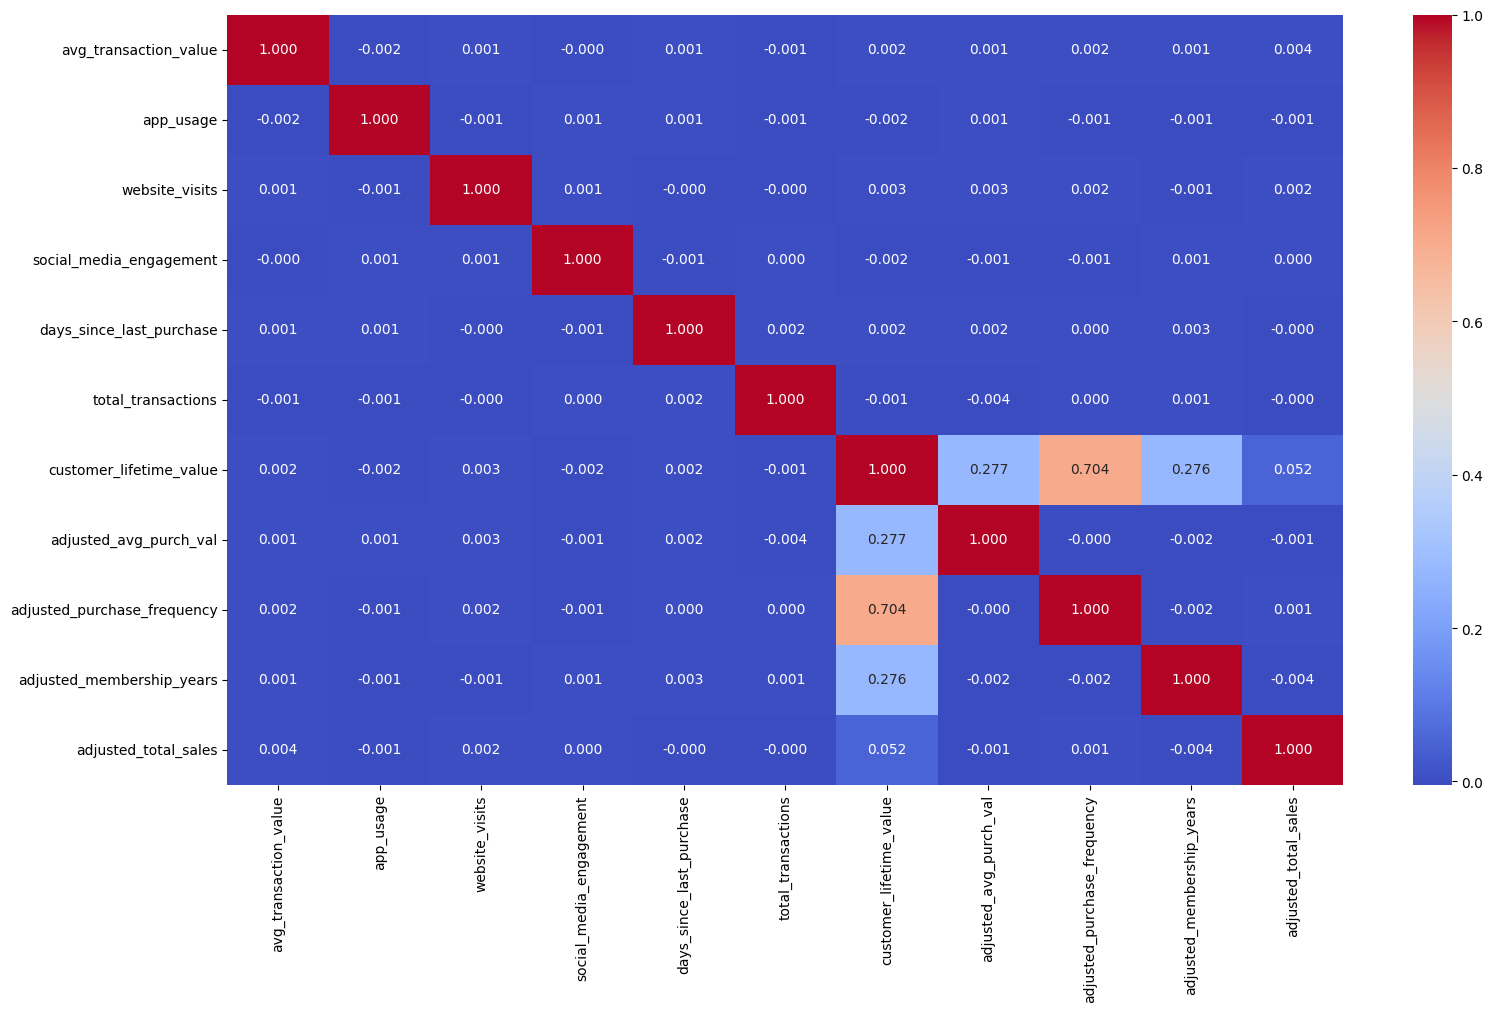

In [45]:
# correlation matrix to visualize relationships
plt.clf()
corr_matrix = lftv_data.corr()
plt.figure(figsize=(18,10))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm')
plt.show()

# Constructing Our X and Y data set plus two more components of our feature engineering

    3) Address skewness, outliers in Y through transformation.
    4) Standard scale numeric features.


In [46]:
summarize_dataframe(lftv_data)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,avg_transaction_value,float64,0,500000,48998
1,app_usage,int64,0,500000,3
2,website_visits,int64,0,500000,100
3,social_media_engagement,int64,0,500000,3
4,days_since_last_purchase,int64,0,500000,365
5,total_transactions,int64,0,500000,99
6,customer_lifetime_value,float64,0,500000,500000
7,adjusted_avg_purch_val,float64,0,500000,500000
8,adjusted_purchase_frequency,float64,0,500000,500000
9,adjusted_membership_years,float64,0,500000,450003


In [47]:
lftv_data.shape

(500000, 11)

In [48]:
lftv_data.head()

,avg_transaction_value,app_usage,website_visits,social_media_engagement,days_since_last_purchase,total_transactions,customer_lifetime_value,adjusted_avg_purch_val,adjusted_purchase_frequency,adjusted_membership_years,adjusted_total_sales
987231,374.84,1,75,3,329,9,65185.342948,436.070823,52.445359,7.734687,4641.927557
79954,127.35,2,77,3,145,40,4924.237356,479.342255,11.067716,0.966936,3120.011481
567130,190.46,2,52,1,95,60,3786.364241,181.676714,53.626157,0.000000,6777.507688
500891,304.81,1,21,1,124,11,44788.675155,398.342473,51.541545,3.205386,10012.068758
55399,136.49,1,69,1,240,17,99992.802636,187.818157,390.082109,2.721934,5421.427767


# Towards x_dataset, and y_dataset  construction
   

In [49]:
#construct our x_data
y_dataset = lftv_data['customer_lifetime_value'].values
x_dataset = lftv_data.drop(columns=['customer_lifetime_value']) # drop the Y label from the X data set

In [50]:
summarize_dataframe(x_dataset)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,avg_transaction_value,float64,0,500000,48998
1,app_usage,int64,0,500000,3
2,website_visits,int64,0,500000,100
3,social_media_engagement,int64,0,500000,3
4,days_since_last_purchase,int64,0,500000,365
5,total_transactions,int64,0,500000,99
6,adjusted_avg_purch_val,float64,0,500000,500000
7,adjusted_purchase_frequency,float64,0,500000,500000
8,adjusted_membership_years,float64,0,500000,450003
9,adjusted_total_sales,float64,0,500000,500000


In [51]:
print(f"{ x_dataset.shape = }, { y_dataset.shape = }")
print(f"{ type(x_dataset) = }, { type(y_dataset) = }")

 x_dataset.shape = (500000, 10),  y_dataset.shape = (500000,)
 type(x_dataset) = <class 'pandas.core.frame.DataFrame'>,  type(y_dataset) = <class 'numpy.ndarray'>


# Workflow:
    1) Split the data into train and test
    2) Look at skewness of Y and log transform to address skewness
    3) Std scale (fit) on train data. Use mean and std dev of train data to std scale test data
        - This prevents data leakage from test to train.

In [52]:
# Split + Std Scale
# Use a 60, 20, 20 split for train, validation and test

# Split into training + temp (Temp = validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(x_dataset, y_dataset, test_size=0.4, random_state=42)

# Now, split Temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("_"*150)
print("SHAPES OF SPLIT DATA SETS")
print("_"*150)
print(f"{ type(X_train) = }, { X_train.shape = }, { type(y_train) = } , { y_train.shape = }")
print(f"{ type(X_val) = }, { X_val.shape = }, { type(y_val) = } , { y_val.shape = }")
print(f"{ type(X_test) = }, { X_test.shape = }, { type(y_test) = } , { y_test.shape = }")
print("_"*150)
print("_"*150)

______________________________________________________________________________________________________________________________________________________
SHAPES OF SPLIT DATA SETS
______________________________________________________________________________________________________________________________________________________
 type(X_train) = <class 'pandas.core.frame.DataFrame'>,  X_train.shape = (300000, 10),  type(y_train) = <class 'numpy.ndarray'> ,  y_train.shape = (300000,)
 type(X_val) = <class 'pandas.core.frame.DataFrame'>,  X_val.shape = (100000, 10),  type(y_val) = <class 'numpy.ndarray'> ,  y_val.shape = (100000,)
 type(X_test) = <class 'pandas.core.frame.DataFrame'>,  X_test.shape = (100000, 10),  type(y_test) = <class 'numpy.ndarray'> ,  y_test.shape = (100000,)
______________________________________________________________________________________________________________________________________________________
______________________________________________________________

<Figure size 640x480 with 0 Axes>

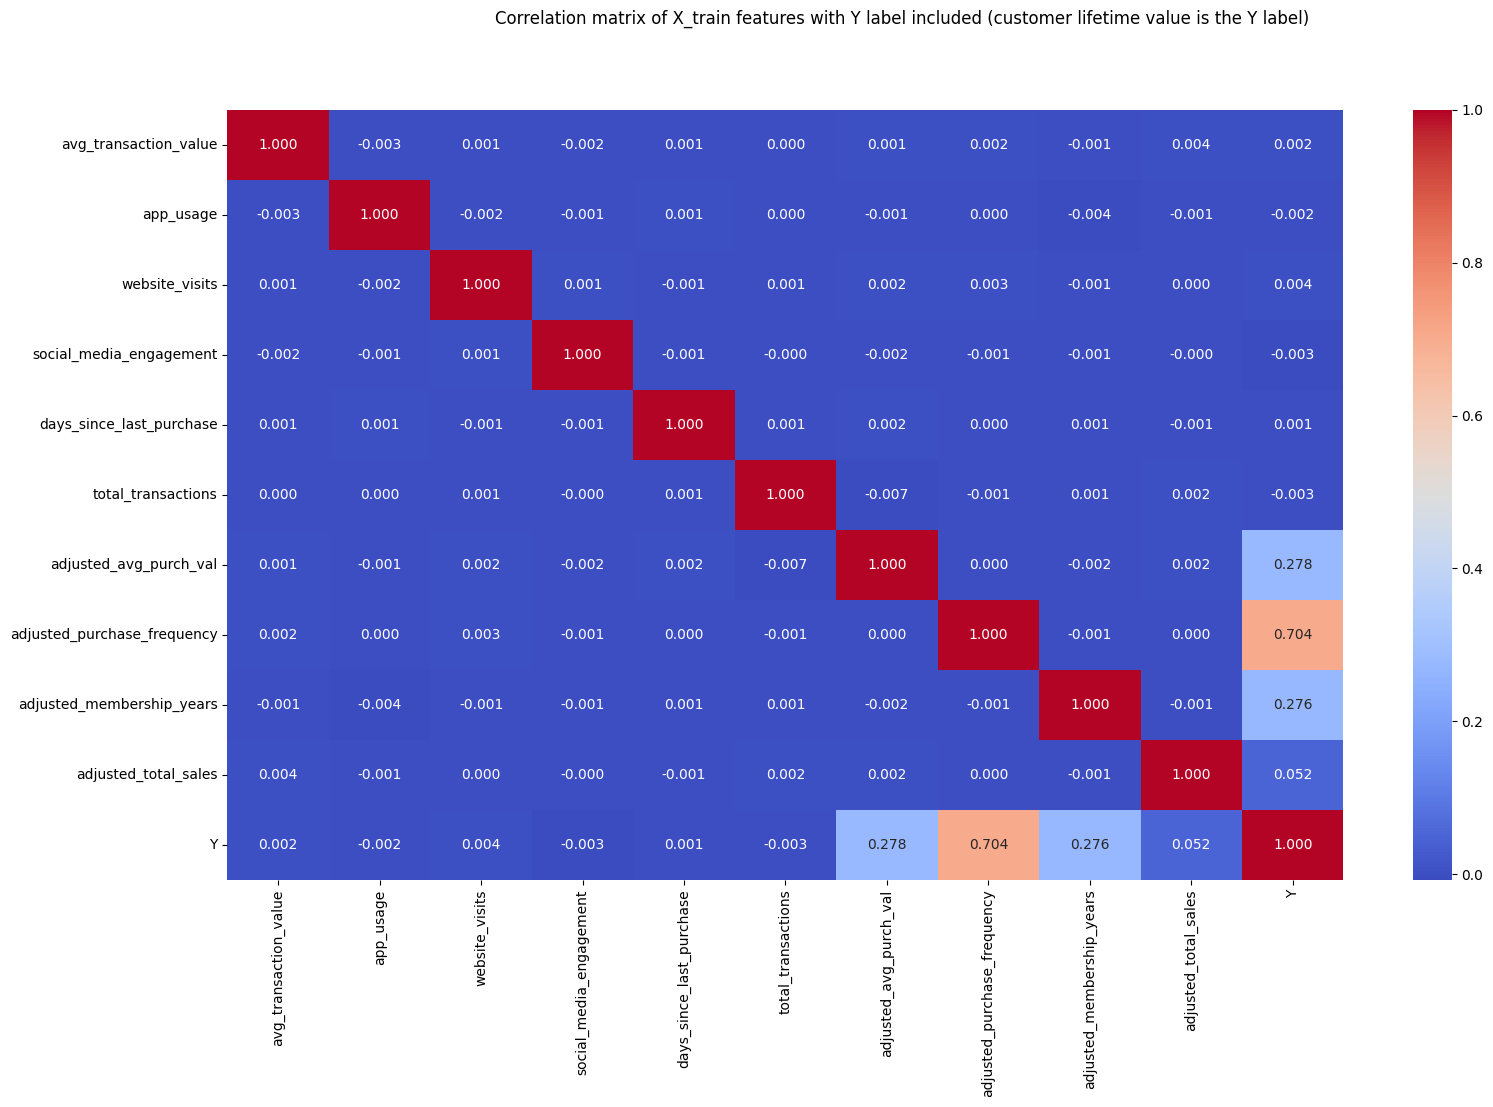

In [53]:
# correlation matrix to visualize relationships on our data set for training
temp_df = X_train.copy()
temp_df['Y'] = y_train
plt.clf()
corr_matrix = temp_df.corr()
plt.figure(figsize=(18,10))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm')
plt.suptitle("Correlation matrix of X_train features with Y label included (customer lifetime value is the Y label)")
plt.show()

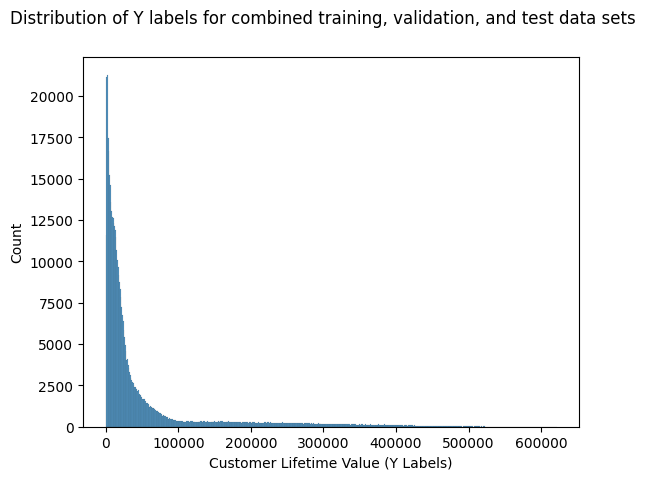

In [54]:
#Visualize distribiution of Y
plt.clf()
vstacked_y = np.concatenate((y_train,y_val,y_test)).flatten()
sns.histplot(vstacked_y)
plt.xlabel('Customer Lifetime Value (Y Labels)')
plt.ylabel('Count')
plt.suptitle('Distribution of Y labels for combined training, validation, and test data sets')

plt.show()

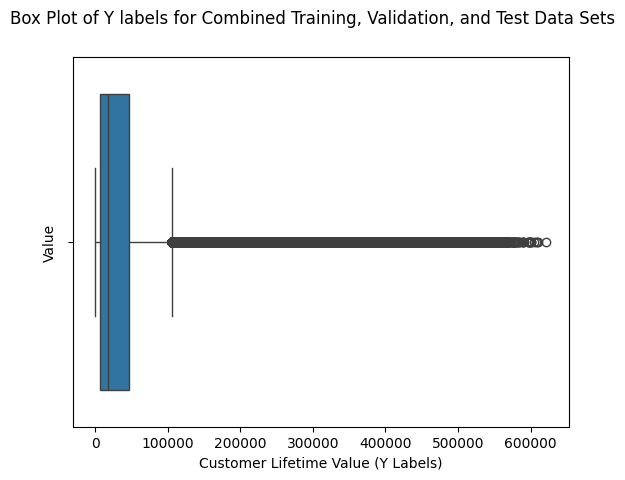

In [55]:
plt.clf()

vstacked_y = np.concatenate((y_train, y_val, y_test)).flatten()

sns.boxplot(x=vstacked_y)

plt.xlabel('Customer Lifetime Value (Y Labels)')
plt.ylabel('Value')
plt.suptitle('Box Plot of Y labels for Combined Training, Validation, and Test Data Sets')

plt.show()

In [56]:
import scipy.stats as stats
import numpy as np

# Assuming y_train contains your Y values for customer lifetime value
y_train = np.array(y_train)  # replace y_train with your actual Y data

# Calculate skewness and kurtosis
skewness = stats.skew(y_train)
kurtosis = stats.kurtosis(y_train)

print("Skewness:", skewness)
print("Kurtosis:", kurtosis)

Skewness: 2.6406105654032195
Kurtosis: 6.8175640697243445


    Skewness of y_train of 2.64 implies right skewed distribution, suggesting a few high value outliers. Kurtosis of 6.84 implies y_train has extreme outliers that can influence model’s predictions.

    To mitigate, we will log transformation on y_train (it is right skewed, log transformation should help); and then standard scale.

    For X_train we will scale only numerical columns, and not one hot or ordinary encoded columns.

# Scaling.


In [57]:
summarize_dataframe(X_train)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,avg_transaction_value,float64,0,300000,48901
1,app_usage,int64,0,300000,3
2,website_visits,int64,0,300000,100
3,social_media_engagement,int64,0,300000,3
4,days_since_last_purchase,int64,0,300000,365
5,total_transactions,int64,0,300000,99
6,adjusted_avg_purch_val,float64,0,300000,300000
7,adjusted_purchase_frequency,float64,0,300000,300000
8,adjusted_membership_years,float64,0,300000,269971
9,adjusted_total_sales,float64,0,300000,300000


In [58]:
X_train.columns

Index(['avg_transaction_value', 'app_usage', 'website_visits',
       'social_media_engagement', 'days_since_last_purchase',
       'total_transactions', 'adjusted_avg_purch_val',
       'adjusted_purchase_frequency', 'adjusted_membership_years',
       'adjusted_total_sales'],
      dtype='object')

In [59]:
# Define numerical columns for X_train (excluding one-hot ordinal, or, nominal encoded columns)
# i.e. exclude app_usage, and social_media_engagement from scaling
###To address skewness of Y, we also do a log transformation on Y; we then standard scale it
numerical_columns_X = ['avg_transaction_value', 'website_visits',
       'days_since_last_purchase',
       'total_transactions', 'adjusted_avg_purch_val',
       'adjusted_purchase_frequency', 'adjusted_membership_years',
       'adjusted_total_sales']

scaler_X = StandardScaler()

# Scale only numerical features in X_train
X_train_std = X_train.copy()
X_train_std[numerical_columns_X] = scaler_X.fit_transform(X_train[numerical_columns_X])

# Log transformation on y_train
y_train_log = np.log1p(y_train)  # log(1 + y) to handle zero values safely

# Standard scaling on the transformed y_train
scaler_y = StandardScaler()
y_train_std = scaler_y.fit_transform(y_train_log.reshape(-1, 1))

# Apply the same transformations to X_val, X_test, and y_val, y_test

X_val_std = X_val.copy()
X_val_std[numerical_columns_X] = scaler_X.transform(X_val[numerical_columns_X])

X_test_std = X_test.copy()
X_test_std[numerical_columns_X] = scaler_X.transform(X_test[numerical_columns_X])

# Log transformation on y_val and y_test
y_val_log = np.log1p(y_val)
y_val_std = scaler_y.transform(y_val_log.reshape(-1, 1))

y_test_log = np.log1p(y_test)
y_test_std = scaler_y.transform(y_test_log.reshape(-1, 1))

# Output: transformed data: X_train_std, X_val_std, X_test_std, y_train_std, y_val_std, y_test_std


In [60]:
print("_"*150)
print("SHAPES OF SPLIT DATA SETS")
print("_"*150)
print(f"{ type(X_train_std) = }, { X_train_std.shape = }, { type(y_train_std) = } , { y_train_std.shape = }")
print(f"{ type(X_val_std) = }, { X_val_std.shape = }, { type(y_val_std) = } , { y_val_std.shape = }")
print(f"{ type(X_test_std) = }, { X_test_std.shape = }, { type(y_test_std) = } , { y_test_std.shape = }")
print("_"*150)
print("_"*150)

______________________________________________________________________________________________________________________________________________________
SHAPES OF SPLIT DATA SETS
______________________________________________________________________________________________________________________________________________________
 type(X_train_std) = <class 'pandas.core.frame.DataFrame'>,  X_train_std.shape = (300000, 10),  type(y_train_std) = <class 'numpy.ndarray'> ,  y_train_std.shape = (300000, 1)
 type(X_val_std) = <class 'pandas.core.frame.DataFrame'>,  X_val_std.shape = (100000, 10),  type(y_val_std) = <class 'numpy.ndarray'> ,  y_val_std.shape = (100000, 1)
 type(X_test_std) = <class 'pandas.core.frame.DataFrame'>,  X_test_std.shape = (100000, 10),  type(y_test_std) = <class 'numpy.ndarray'> ,  y_test_std.shape = (100000, 1)
______________________________________________________________________________________________________________________________________________________
________

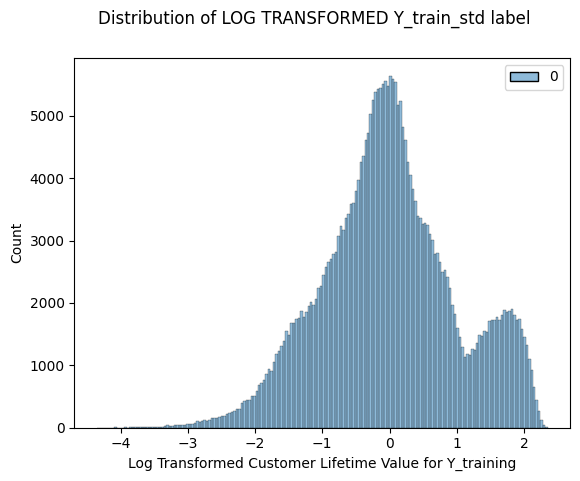

In [61]:
#Visualize distribiution of Y
plt.clf()
sns.histplot(y_train_std)
plt.xlabel('Log Transformed Customer Lifetime Value for Y_training')
plt.ylabel('Count')
plt.suptitle('Distribution of LOG TRANSFORMED Y_train_std label')

plt.show()

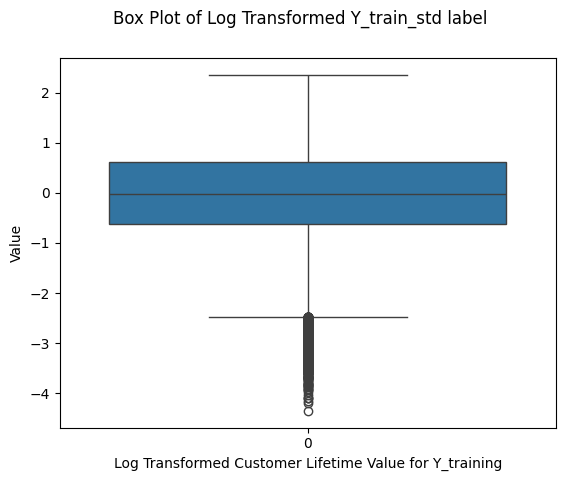

In [62]:
# Visualize transformed y distribution
plt.clf()

sns.boxplot(y_train_std)

plt.xlabel('Log Transformed Customer Lifetime Value for Y_training')
plt.ylabel('Value')
plt.suptitle('Box Plot of Log Transformed Y_train_std label')

plt.show()

# Impact of our Log Transformation on y_train_std

    The y_train_std's original right skewed distribution looks closer to a normal distribution (good, suggesting our log transformation was helpful), and the box plot of transformed y_train_std shows that some outliers still exist that can negatively impact some of our linear regression models. But we will retain them.

    Note: Even though we applied log transformation and standard scaling to to val and test Y's as well, we do not show their distribution or plots to prevent 'information leakage' and maintain integrity of our work.  

# Preparation for Model run

#
    scaler_y is now our State Variable that will be required throughout for reverse transformation to recover oroginal Y values

In [63]:
# Utility function to reverse transform

def compute_rmse_on_original_scale(y_pred_train, y_pred_val, y_train_std, y_val_std, scaler_y):
    """
    Computes the Train and Validation RMSE on the original scale after inverse transformations (log transformed y).

    Parameters:
    - y_pred_train: The predicted values on the standardized scale for the training set.
    - y_pred_val: The predicted values on the standardized scale for the validation set.
    - y_train_std: The standardized training target variable (after log transformation).
    - y_val_std: The standardized validation target variable (after log transformation).
    - scaler_y: The scaler used for standard scaling of y (should be fitted to y_train).

    Returns:
    - y_train_original, y_val_original
    - train_rmse: The RMSE on the original scale for the training set.
    - val_rmse: The RMSE on the original scale for the validation set.
    """

    # Inverse scaling of predictions
    y_pred_train_inv = scaler_y.inverse_transform(y_pred_train).flatten()
    y_pred_val_inv = scaler_y.inverse_transform(y_pred_val).flatten()

    # Reverse the log transformation for predictions
    y_pred_train_original = np.expm1(y_pred_train_inv)  # exp(y) - 1 to reverse log1p
    y_pred_val_original = np.expm1(y_pred_val_inv)  # exp(y) - 1 to reverse log1p

    # Inverse scaling for actual target values
    y_train_inv = scaler_y.inverse_transform(y_train_std).flatten()
    y_val_inv = scaler_y.inverse_transform(y_val_std).flatten()

    # Reverse the log transformation for actual values
    y_train_original = np.expm1(y_train_inv)  # exp(y) - 1 to reverse log1p
    y_val_original = np.expm1(y_val_inv)  # exp(y) - 1 to reverse log1p

    # Calculate RMSE on original scale
    train_rmse = np.sqrt(mean_squared_error(y_train_original, y_pred_train_original))
    val_rmse = np.sqrt(mean_squared_error(y_val_original, y_pred_val_original))

    return y_train_original, y_val_original, train_rmse, val_rmse



# ________________________SECTION FOR MODEL RUN_______________

# Model 0: Simple Linear Regression

In [64]:
model = LinearRegression()
model.fit(X_train_std, y_train_std)

y_pred_train = model.predict(X_train_std)
y_pred_val = model.predict(X_val_std)

y_train_original, y_val_original, train_rmse, val_rmse = compute_rmse_on_original_scale(y_pred_train, y_pred_val, y_train_std, y_val_std, scaler_y)


In [65]:
print("_"*125)
print("Model 0: Simple Linear Regression Model Results")
print("_"*125)
print(f"Train RMSE on original scale: {train_rmse:.2f}")
print(f"Validation RMSE on original scale: {val_rmse:.2f}")
mean_train_Y, mean_val_Y = np.mean(y_train_original), np.mean(y_val_original)
print(f"mean_train_Y = {mean_train_Y:.2f}, mean_val_Y = {mean_val_Y:.2f}")
print(f"Train RMSE  = {(train_rmse/ mean_train_Y)*100:.2f}%,\n Validation RMSE  = {(val_rmse/ mean_val_Y)*100:.2f}%")
print("_"*125)

_____________________________________________________________________________________________________________________________
Model 0: Simple Linear Regression Model Results
_____________________________________________________________________________________________________________________________
Train RMSE on original scale: 49418.41
Validation RMSE on original scale: 48934.44
mean_train_Y = 53126.77, mean_val_Y = 52890.50
Train RMSE  = 93.02%,
 Validation RMSE  = 92.52%
_____________________________________________________________________________________________________________________________


# Model 1: FFNN

In [68]:
# Define the model using the Functional API
inputs = layers.Input(shape=(X_train_std.shape[1],))

x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)

# Output layer for regression (single output neuron)
outputs = layers.Dense(1)(x)

# Create the model
model = models.Model(inputs=inputs, outputs=outputs)

# Compile the model with appropriate loss and optimizer
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │             704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Train the model with early stopping callback
history = model.fit(X_train_std, y_train_std, epochs=100, batch_size=32,
                    validation_data=(X_val_std, y_val_std),
                    callbacks=[early_stopping])

Epoch 1/100
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0758 - mae: 0.1741 - val_loss: 0.0113 - val_mae: 0.0826
Epoch 2/100
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0111 - mae: 0.0823 - val_loss: 0.0084 - val_mae: 0.0726
Epoch 3/100
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0092 - mae: 0.0754 - val_loss: 0.0084 - val_mae: 0.0733
Epoch 4/100
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0083 - mae: 0.0717 - val_loss: 0.0100 - val_mae: 0.0758
Epoch 5/100
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0083 - mae: 0.0714 - val_loss: 0.0078 - val_mae: 0.0702
Epoch 6/100
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0078 - mae: 0.0695 - val_loss: 0.0083 - val_mae: 0.0707
Epoch 7/100
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0078 - mae: 0.0696 - val_loss: 0.0076 - val_mae: 0.0695
Epoch 8/100
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.0075 - mae: 0.0686 - val_loss: 0.0078 - val_mae: 0.0698
Epoch 9/100
9375/9375 ━━

<Figure size 640x480 with 0 Axes>

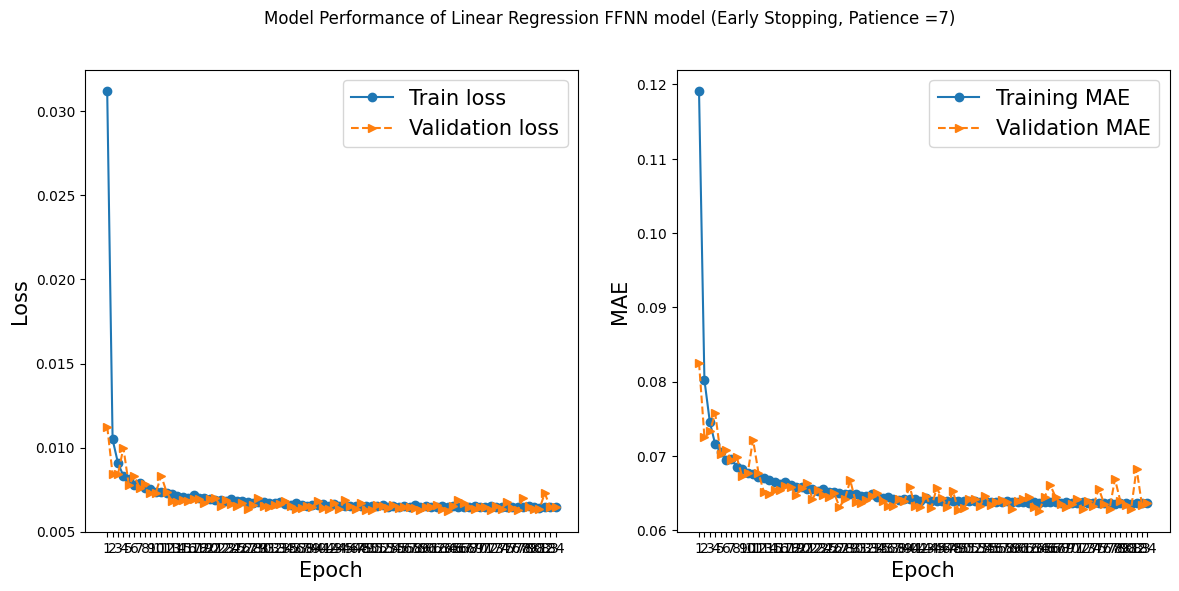

In [70]:
#Visualization
# plot loss curves
plt.clf()
hist = history.history
x_data = np.arange(len(hist['loss'])) + 1

fix, axes = plt.subplots(1,2, figsize=(14,6))
axes = axes.flatten()

###we print losses to prevent the extremely high first epoch training loss from impacting plot resolution
axes[0].plot(x_data, hist['loss'], '-o', label='Train loss')
axes[0].plot(x_data, hist['val_loss'], '-->', label='Validation loss')
axes[0].legend(fontsize=15)
axes[0].set_xlabel('Epoch', size=15)
axes[0].set_ylabel('Loss', size=15)
ticks = x_data
axes[0].set_xticks(ticks)
#axes[1].set_ylim(0,3) ## trying to prevent the high first epoch training loss from

axes[1].plot(x_data, hist['mae'], '-o', label='Training MAE')
axes[1].plot(x_data, hist['val_mae'], '-->', label='Validation MAE')
axes[1].legend(fontsize=15)
axes[1].set_xlabel('Epoch', size=15)
axes[1].set_ylabel('MAE', size=15)
#axes[1].set_ylim(0,1)
ticks = x_data
axes[1].set_xticks(ticks)
plt.suptitle("Model Performance of Linear Regression FFNN model (Early Stopping, Patience =7)")
plt.show()

In [76]:
model.save('best_ffnn_lftv_apr6.h5')
model.save('best_ffnn_lftv_apr6.keras')



In [77]:
best_model = load_model('best_ffnn_lftv_apr6.keras')

In [79]:
y_pred_train = best_model.predict(X_train_std)
y_pred_val = best_model.predict(X_val_std)

9375/9375 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [81]:
y_train_original, y_val_original, train_rmse, val_rmse = compute_rmse_on_original_scale(y_pred_train, y_pred_val, y_train_std, y_val_std, scaler_y)

In [82]:
print("_"*125)
print("Model 1: FFNN Regression Model Results")
print("_"*125)
print(f"Train RMSE on original scale: {train_rmse:.2f}")
print(f"Validation RMSE on original scale: {val_rmse:.2f}")
mean_train_Y, mean_val_Y = np.mean(y_train_original), np.mean(y_val_original)
print(f"mean_train_Y = {mean_train_Y:.2f}, mean_val_Y = {mean_val_Y:.2f}")
print(f"Train RMSE  = {(train_rmse/ mean_train_Y)*100:.2f}%,\n Validation RMSE  = {(val_rmse/ mean_val_Y)*100:.2f}%")
print("_"*125)

_____________________________________________________________________________________________________________________________
Model 1: FFNN Regression Model Results
_____________________________________________________________________________________________________________________________
Train RMSE on original scale: 12219.00
Validation RMSE on original scale: 12255.05
mean_train_Y = 53126.77, mean_val_Y = 52890.50
Train RMSE  = 23.00%,
 Validation RMSE  = 23.17%
_____________________________________________________________________________________________________________________________


# Comments
  Our previous run’s validation RMSE were, log transformed Y, but no ‘heart beat features’:
	Simple Linear Regression Model (file APR 5), 178.29%
	FFNN, 178 % (file APR5)


  Our this run’s validation RMSE, log transformed Y, noise-including ‘heart beat’ features:
	Simple Linear Regression Model (file APR 6, Colab): 92.52%
	FFNN, Validation RMSE (file APR 6, Colab): 23.17%


  Between Runs 1 and 2, we reduced the Validation RMSE from 178% to 23.17% (an improvement of 87%).

  This best FFNN model is saved as 'best_ffnn_lftv_apr6.keras’.

  WE will not do further optimization as we have reached here through a lot of experimentation (multiple grid searches covering different sets of features, and models such as Simple LR, grid searched FFNN, and grid searched Random Forest Regressor, and grid searched His Gradient Boost Regressor. Most of these runs take upwards of 1 hour on paid GPU time on Colab (even with early stopping).

  We will run inference with our best FFNN model


In [83]:
def compute_test_rmse_on_original_scale(y_pred_test, y_test_std, scaler_y):
    """
    Computes the Test RMSE on the original scale after inverse transformations (log transformed y).

    Parameters:
    - y_pred_test: The predicted values on the standardized scale for the test set.
    - y_test_std: The standardized test target variable (after log transformation).
    - scaler_y: The scaler used for standard scaling of y (should be fitted to y_train).

    Returns:
    - y_test_original: The actual target values on the original scale.
    - y_pred_test_original: The predicted target values on the original scale.
    - test_rmse: The RMSE on the original scale for the test set.
    """
    y_pred_test_inv = scaler_y.inverse_transform(y_pred_test).flatten()
    y_pred_test_original = np.expm1(y_pred_test_inv)
    y_test_inv = scaler_y.inverse_transform(y_test_std).flatten()
    y_test_original = np.expm1(y_test_inv)
    test_rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_test_original))
    return y_test_original, y_pred_test_original, test_rmse

In [84]:
#Lets do inference
y_test_pred = best_model.predict(X_test_std)

# Compute RMSE on original scale
y_test_original, y_pred_test_original, test_rmse = compute_test_rmse_on_original_scale(
    y_pred_test=y_test_pred,
    y_test_std=y_test_std,
    scaler_y=scaler_y
)

print(f"Test RMSE (original scale): {test_rmse:.4f}")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Test RMSE (original scale): 12472.1726


In [85]:
print("_"*125)
print("Model 1: FFNN Regression Model Results (Inference)")
print("_"*125)
print(f"Test RMSE on original scale: {test_rmse:.2f}")


mean_test_Y = np.mean(y_test_original)
print(f"mean_test_Y = {mean_test_Y:.2f}")
print(f"Test RMSE  = {(test_rmse/ mean_test_Y)*100:.2f}%")
print("_"*125)

_____________________________________________________________________________________________________________________________
Model 1: FFNN Regression Model Results (Inference)
_____________________________________________________________________________________________________________________________
Test RMSE on original scale: 12472.17
mean_test_Y = 53491.00
Test RMSE  = 23.32%
_____________________________________________________________________________________________________________________________


# Wrap Up
   LFTV best model file:



*   Best FFNN model file: 'best_ffnn_lftv_apr6.keras', April 6
*   Notebook file: 207_FP_LFTV_Run_2_VSAPR6_CL_Final.pynb

Now we want to save the data set that had 500K rows and that fed this run, for use in Customer segmentation. We would like to run segmentation model on the same Customer IDs



In [86]:
retail_df = retail_df.sample(n=RANDOM_SAMPLES_VAL, random_state=RANDOM_STATE)

In [87]:
from google.colab import drive, files

# Mount Google Drive
drive.mount('/content/drive')

# Save CSV to Google Drive
retail_df.to_csv('/content/drive/MyDrive/retail_clv.csv', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
